# Final Project Group 404-not-found
Forked from here: https://github.com/pytorch/examples

## Import Library

In [1]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np


## Import Data

In [2]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    npimg = npimg-np.amin(npimg)
    npimg = npimg/np.amax(npimg)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis("off")
        
    plt.show()

In [3]:
# We will save the results here
outf="./dcgan_results"

In [4]:
#manualSeed = random.randint(1, 10000)
manualSeed = 4532
print("Random Seed: ", manualSeed)
random.seed(manualSeed)

torch.manual_seed(manualSeed)
cudnn.benchmark = True

use_cuda=True
if use_cuda:
    torch.cuda.manual_seed_all(manualSeed)

if torch.cuda.is_available() and not use_cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

Random Seed:  4532


In [8]:
imageSize = 64 
dataroot = "."

# folder dataset
dataset = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Scale(imageSize),
                                   transforms.CenterCrop(imageSize),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))

In [9]:
batchSize= 32
workers = 2
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=int(workers))

In [10]:
print('num of batches:', dataloader.__len__())
print('num Of Images:', dataloader.__len__()*batchSize)

num of batches: 128
num Of Images: 4096


In [11]:
# this example demonstrates how we can load a new batch of data
dataiter = iter(dataloader)
data= dataiter.next()
data[0]=(data[0]+1)/2
print(len(data))
print(data[0].size(),data[1].size())

2
torch.Size([32, 3, 64, 64]) torch.Size([32])


In [12]:
#labels are in data[1][:]
data[1][0:5]

tensor([4, 4, 4, 4, 4])

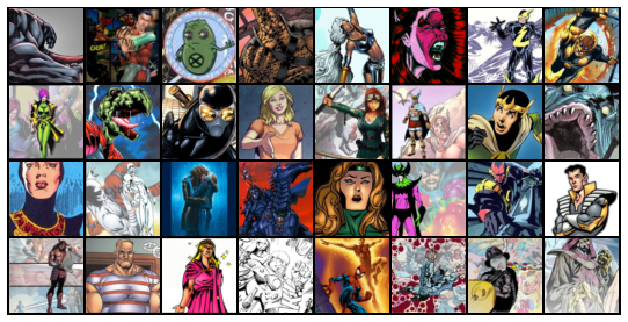

In [13]:
# show some examples from the original data
# images are in data[0][:]
show(make_grid(data[0]))

## Algorithm Impletetion

In [14]:
ngpu = int(1) # use one GPU
nz = int(100) # code dimension (This is the() random noise) input dimension of the generator network)
ngf = int(64) # output dimension of the generator network
ndf = int(64) # input dim (image size) for the discriminator net
nc = 3 # number of input channels (e.g. 3 for RGB channels)

In [15]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [16]:
# Let us create the Generator network
class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


In [17]:
netG = _netG(ngpu)
netG.apply(weights_init)

# if we want to load a saved netG, we can do it here:
#savednetG=outf+"/netG_epoch_39.pth"
#netG.load_state_dict(torch.load(savednetG))
print(netG)


_netG(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [18]:
# Let us create the Discriminator network
class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


In [19]:
netD = _netD(ngpu)
netD.apply(weights_init)

#netD.load_state_dict(torch.load(savednetD))
print(netD)


_netD(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [20]:
# Binary Cross Entropy between the target (p, 1-p) and the output (q,1-q) distributions
criterion = nn.BCELoss()

In [21]:
input = torch.FloatTensor(batchSize, 3, imageSize, imageSize) # this will be the input of the Discriminator network

noise = torch.FloatTensor(batchSize, nz, 1, 1) # this will be the input of the Generator network

# We will also use some "fixed" noise to monitor the progess of the generated data
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)

label = torch.FloatTensor(batchSize)

In [22]:
real_label = 1
fake_label = 0

In [23]:
# put NetD, netG, the criterion, input, and noise to the GPUs
if use_cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

In [24]:
fixed_noise = Variable(fixed_noise)

In [25]:
# setup optimizer

beta1 =0.5
lr=0.0002

optimizerD = optim.Adam(netD.parameters(), lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr, betas=(beta1, 0.999))

#optimizerD = optim.SGD(netD.parameters(), lr=0.001, momentum=0.9)
#optimizerG = optim.SGD(netG.parameters(), lr=0.001, momentum=0.9)

## Main Process

In [57]:
use_cuda=True
for epoch in range(50):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        if use_cuda:
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()
        
        

        if i % 100 == 0:
            vutils.save_image(real_cpu,'%s/real_samples.png' % outf,normalize=True)
            fake = netG(fixed_noise)
            #show(make_grid(fake.data.cpu()))
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)


In [58]:
# do checkpointing
torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

## Generate new images

In [59]:
noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
noise = noise.cuda()
noisev = Variable(noise)
fake = netG(noisev)
fake.size()

torch.Size([32, 3, 64, 64])

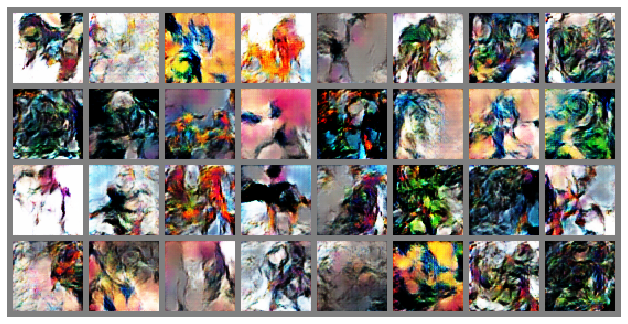

In [60]:
fake=fake.cpu()
show(make_grid(fake.data, padding=5))

## Style Transfer